# Tutorial 9: Regression Continued

**Regression learning objectives**: 

* Recognize situations where a simple regression analysis would be appropriate for making predictions.
* Explain the $k$-nearest neighbour ($k$-nn) regression algorithm and describe how it differs from k-nn classification.
* Interpret the output of a $k$-nn regression.
* In a dataset with two variables, perform $k$-nearest neighbour regression in R using `tidymodels` to predict the values for a test dataset.
* Using R, execute cross-validation in R to choose the number of neighbours.
* Using R, evaluate $k$-nn regression prediction accuracy using  a test data set and an appropriate metric (*e.g.*, root means square prediction error).
* In a dataset with > 2 variables, perform $k$-nn regression in R using `tidymodels` to predict the values for a test dataset.
* In the context of $k$-nn regression, compare and contrast goodness of fit and prediction properties (namely RMSE vs RMSPE).
* Describe advantages and disadvantages of the $k$-nearest neighbour regression approach.
* Perform ordinary least squares regression in R using `tidymodels` to predict the values for a test dataset.
* Compare and contrast predictions obtained from $k$-nearest neighbour regression to those obtained using simple ordinary least squares regression from the same dataset.
* In R, overlay the ordinary least squares regression lines from `geom_smooth` on a single plot. 

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

## Predicting credit card balance

<img src='https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif' align="left" width='400'>

Source: https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif

Here in this worksheet we will work with a simulated data set that contains information that we can use to create a model to predict customer credit card balance. A bank might use such information to predict which customers might be the most profitable to lend to (customers who carry a balance, but do not default, for example).

Specifically, we wish to build a model to predict credit card balance (`Balance` column) based on income (`Income` column) and credit rating (`Rating` column).

We access this data set by accessing it from an R data package that we loaded at the beginning of the worksheet, `ISLR`. Loading that package gives access to a variety of data sets, including the `Credit` data set that we will be working with.

In [2]:
Credit

ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
398,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
399,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0
400,18.701,5524,415,5,64,7,Female,No,No,Asian,966


In [6]:
hp = -0.01912*100
hp

cyl = -2.26469*4
cyl

mpg = 36.90833 + hp + cyl
mpg

[1] -1.912

[1] -9.05876

[1] 25.93757

**Question 1.1**
<br> {points: 1}

Select only the columns of data we are interested in using for our prediction (both the predictors and the response variable) and use the `as_tibble` function to convert it to a tibble (it is currently a base R data frame). Name the modified data frame `credit` (using a lowercase c).

*Note: We could alternatively just leave these variables in and use our recipe formula below to specify our predictors and response. But for this worksheet, let's select the relevant columns first.*

In [5]:
credit <- Credit %>%
    as_tibble() %>%
    select(Balance, Income, Rating)

In [6]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br> {points: 1}

**Before** we perform exploratory data analysis, we should create our training and testing data sets. First, split the `credit` data set. Use 60% of the data and set the variables we want to predict as the `strata` argument. Assign your answer to an object called `credit_split`.

Assign your training data set to an object called `credit_training` and your testing data set to an object called `credit_testing`. 

In [15]:
set.seed(2000)
credit_split <- initial_split(credit, prop = 0.6, strata = Balance)
credit_training <- training(credit_split)
credit_testing <- testing(credit_split)

In [16]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Using only the observations in the training data set, create a `ggpairs` scatterplot of all the columns we are interested in including in our model. Name the plot object `credit_eda`.

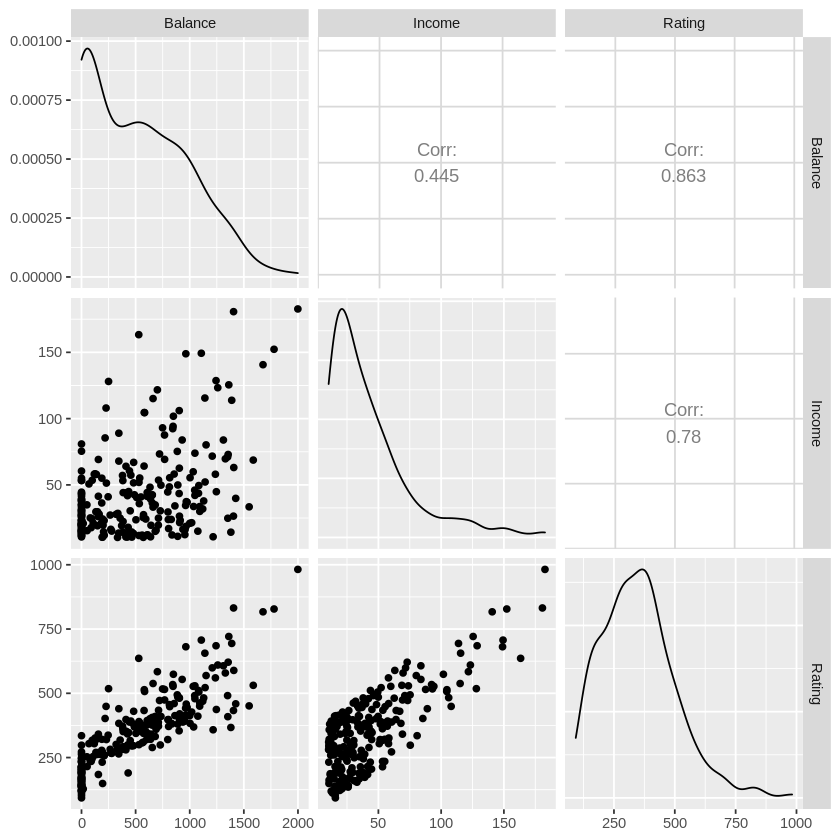

In [17]:
credit_eda <- ggpairs(credit_training)
credit_eda

In [18]:
test_1.3()

[1] "Success!"


**Question 1.4** Multiple Choice:
<br> {points: 1} 

Looking at the `ggpairs` plot above, which of the following statements is **incorrect**?

A. There is a strong positive relationship between the response variable (`Balance`) and the `Rating` predictor

B. There is a strong positive relationship between the two predictors (`Income` and `Rating`)

C. There is a strong positive relationship between the response variable (`Balance`) and the `Income` predictor

D. None of the above statements are incorrect

*Assign your answer to an object called `answer1.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [25]:
answer1.4 <- "C"

In [26]:
test_1.4()

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Now that we have our training data, we will fit a linear regression model.

- Create and assign your linear regression model specification to an object called `lm_spec`.  
- Create a recipe for the model. Assign your answer to an object called `credit_recipe`.

In [30]:
set.seed(2020) #DO NOT REMOVE

lm_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

credit_recipe <- recipe(Balance ~ ., data = credit_training)

print(lm_spec)
print(credit_recipe)

Linear Regression Model Specification (regression)

Computational engine: lm 

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2


In [31]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 1}

Now that we have our model specification and recipe, let's put them together in a workflow, and fit our simple linear regression model. Assign the fit to an object called `credit_fit`. 

In [35]:
set.seed(2020) # DO NOT REMOVE

credit_fit <- workflow() %>%
    add_recipe(credit_recipe) %>%
    add_model(lm_spec) %>%
    fit(credit_training)
credit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       Income       Rating  
   -531.116       -7.960        3.985  


In [34]:
test_1.6()

[1] "Success!"


**Question 1.7** Multiple Choice:
<br> {points: 1}

Looking at the slopes/coefficients above from each of the predictors, which of the following mathematical equations is correct for your prediction model?

A. $credit\: card \: balance = -531.116 -7.960*income  + 3.985*credit\: card\: rating$

B. $credit\: card \: balance = -531.116 + 3.985*income  -7.960*credit\: card\: rating$

C. $credit\: card \: balance = 531.116 -7.960*income  - 3.985*credit\: card\: rating$

D. $credit\: card \: balance = 531.116 - 3.985*income  + 7.960*credit\: card\: rating$

*Assign your answer to an object called `answer1.7`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [36]:
answer1.7 <- "A"

In [37]:
test_1.7()

[1] "Success!"


**Question 1.8**
<br> {points: 1}

Calculate the $RMSE$ to assess goodness of fit on `credit_fit` (remember this is how well it predicts on the training data used to fit the model). Return a single numerical value named `lm_rmse`.

In [45]:
set.seed(2020) # DO NOT REMOVE

#... <- credit_fit %>%
#         predict(...) %>%
#         bind_cols(...) %>%
#         ...(truth = ..., estimate = ...) %>%
#         filter(.metric == ...) %>%
#         select(...) %>%
#         pull()

lm_rmse <- credit_fit %>%
    predict(credit_training) %>%
    bind_cols(credit_training) %>%
    metrics(truth = Balance, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()
lm_rmse

[1] 160.678

In [46]:
test_1.8()

[1] "Success!"


**Question 1.9**
<br> {points: 1}

Calculate $RMSPE$ using the test data. Return a single numerical value named `lm_rmspe`.

In [50]:
set.seed(2020) # DO NOT REMOVE

lm_rmspe <- credit_fit %>%
    predict(credit_testing) %>%
    bind_cols(credit_testing) %>%
    metrics(truth = Balance, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()
lm_rmspe

[1] 165.0795

In [51]:
test_1.9()

[1] "Success!"


**Question 1.9.1**
<br> {points: 3}

Redo this analysis using $k$-nn regression instead of linear regression. Use `set.seed(2000)` at the beginning of this code cell to make it reproducible. Use the same predictors and train - test data splits as you used for linear regression, and use 5-fold cross validation to choose $k$ from the range 1-20. Remember to scale and shift your predictors on your training data, and to apply that same standardization to your test data! 
Assign a single numeric value for $RMSPE$ for your k-nn model as your answer, and name it `knn_rmspe`. 

In [21]:
set.seed(2000) # DO NOT REMOVE

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

knn_recipe <- recipe(Balance ~ ., neighbors = tune()) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) 

knn_vfold <- vfold_cv(credit_training, v = 5, strata = Balance)

knn_workflow <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model

# credit_knn_recipe <- recipe(Balance ~., data = credit_training) %>%
#                         step_center(all_predictors()) %>%
#                         step_scale(all_predictors())

# credit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
#                       set_engine("kknn") %>%
#                       set_mode("regression")

# credit_vfold <- vfold_cv(credit_training, v = 5, strata = Balance)

# credit_knn_workflow <- workflow() %>%
#                         add_recipe(credit_knn_recipe) %>%
#                         add_model(credit_knn_spec)

# gridvals <- tibble(neighbors = seq(1,20))

# credit_knn_results <- credit_knn_workflow %>%
#                        tune_grid(resamples = credit_vfold, grid = gridvals) %>%
#                        collect_metrics() 

# #select the value of k resulting in best RMSE
# kmin <- credit_knn_results %>%
#                filter(.metric == 'rmse') %>%
#                filter(mean == min(mean))  %>% 
#                pull(neighbors)

# #retrain the model using that final k, predict on held-out data
# credit_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
#   set_engine("kknn") %>%
#   set_mode("regression")

# credit_fit <- workflow() %>%
#   add_recipe(credit_knn_recipe) %>%
#   add_model(credit_spec) %>%
#   fit(data = credit_training)

# knn_rmspe <- credit_fit %>%
#   predict(credit_testing) %>%
#   bind_cols(credit_testing) %>%
#   metrics(truth = Balance, estimate = .pred)%>%
#   filter(.metric == 'rmse') %>%
#   pull(.estimate) 

[1] 6

[1] 181.9761

**Question 1.9.2** 
<br> {points: 3}

Discuss which model, linear regression versus $k$-nn regression, gives better predictions and why you think that might be happening.

The linear regression gives better prediction than the KNN regression as the rmspe value is lower for the linear regression model. The linear regression model is also more interpretable because we can mathematically calculate and explain how each predictor is influencing the predictions. For the reason why KNN regression having a higher RMSPE value than the linear regression is that the model overfits the data, the model is influenced too much by the training data compare to the linear regression model

## 2. Ames Housing Prices

<img src="https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif

If we take a look at the Business Insider report [What do millenials want in a home?](https://www.businessinsider.com/what-do-millennials-want-in-a-home-2017-2), we can see that millenials like newer houses that have their own defined spaces. Today we are going to be looking at housing data to understand how the sale price of a house is determined. Finding highly detailed housing data with the final sale prices is very hard, however researchers from Truman State Univeristy have studied and made available a dataset containing multiple variables for the city of Ames, Iowa. The data set describes the sale of individual residential property in Ames, Iowa
from 2006 to 2010. You can read more about the data set [here](http://jse.amstat.org/v19n3/decock.pdf). Today we will be looking at 5 different variables to predict the sale price of a house. These variables are: 

- Lot Area: `lot_area`
- Year Built: `year_built`
- Basement Square Footage: `bsmt_sf`
- First Floor Square Footage: `first_sf`
- Second Floor Square Footage: `second_sf`

First, load the data with the script given below. 

In [52]:
# run this cell

ames_data <- read_csv('data/ames.csv', col_types = cols()) %>%
    select(lot_area = Lot.Area, 
           year_built = Year.Built, 
           bsmt_sf = Total.Bsmt.SF, 
           first_sf = `X1st.Flr.SF`, 
           second_sf = `X2nd.Flr.SF`, 
           sale_price = SalePrice) %>%
    filter(!is.na(bsmt_sf))

ames_data

Warning message:
“13 parsing failures.
 row     col           expected actual            file
1064 Pool.QC 1/0/T/F/TRUE/FALSE     Ex 'data/ames.csv'
1499 Pool.QC 1/0/T/F/TRUE/FALSE     Gd 'data/ames.csv'
1567 Pool.QC 1/0/T/F/TRUE/FALSE     Gd 'data/ames.csv'
1761 Pool.QC 1/0/T/F/TRUE/FALSE     Ex 'data/ames.csv'
1941 Pool.QC 1/0/T/F/TRUE/FALSE     TA 'data/ames.csv'
.... ....... .................. ...... ...............
See problems(...) for more details.
”


lot_area,year_built,bsmt_sf,first_sf,second_sf,sale_price
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31770,1960,1080,1656,0,215000
11622,1961,882,896,0,105000
14267,1958,1329,1329,0,172000
⋮,⋮,⋮,⋮,⋮,⋮
10441,1992,912,970,0,132000
10010,1974,1389,1389,0,170000
9627,1993,996,996,1004,188000


**Question 2.1**
<br> {points: 3}

Split the data into a train dataset and a test dataset, based on a 70%-30% train-test split. Use `set.seed(2019)`. Remember that we want to predict the `sale_price` based on all of the other variables. 

Assign the objects to `ames_split`, `ames_training`, and `ames_testing`, respectively. 

*Use 2019 as your seed for the split.*

In [53]:
set.seed(2019) # DO NOT CHANGE!

ames_split <- initial_split(ames_data, props = 0.7, strata = sale_price)
ames_training <- training(ames_split) 
ames_testing <- testing(ames_split)

In [54]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create objects named ames_split, ames_training and ames_testing', {
    expect_true(exists("ames_split")) 
    expect_true(exists("ames_training")) 
    expect_true(exists("ames_testing"))  
    })

**Question 2.2**
<br> {points: 3}

Let's start by exploring the training data. Use the `ggpairs()` function from the GGally package to explore the relationships between the different variables. 

Assign your plot object to a variable named `answer2.2`. 

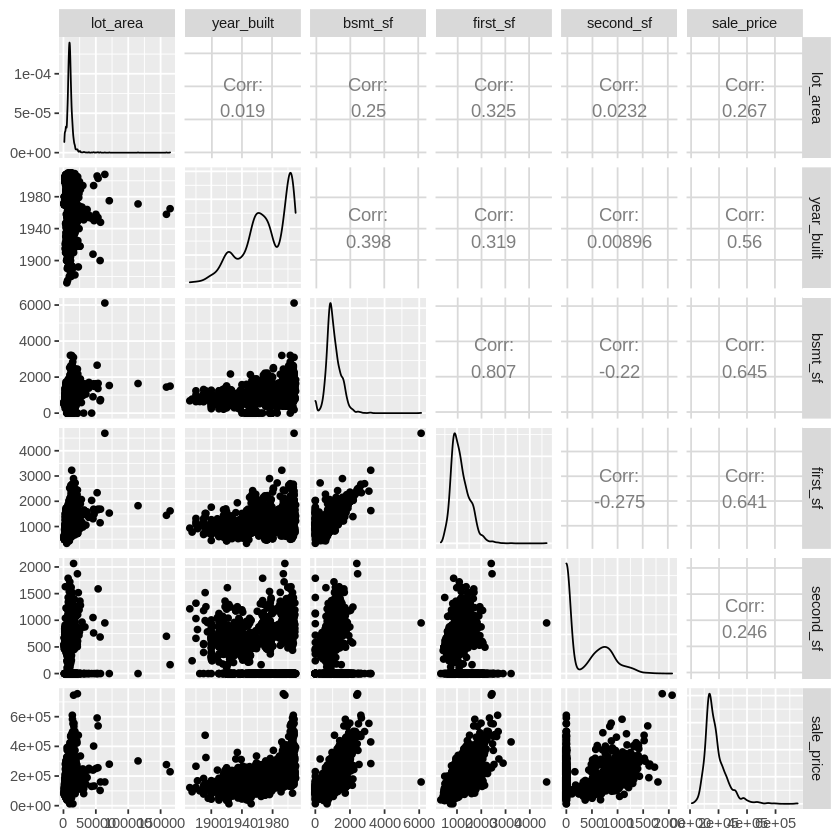

In [55]:
set.seed(2020) # DO NOT REMOVE

answer2.2 <- ggpairs(ames_training) 
answer2.2

In [56]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create a plot named answer2.2', {
    expect_true(exists("answer2.2")) 
})


**Question 2.3** Multiple Choice:
<br> {points: 1}

Now that we have seen all the relationships between the variables, which of the following variables would *not* be a  strong predictor for `sale_price`?

A. `bsmt_sf`

B. `year_built`

C. `first_sf`

D. `lot_area`

E. `second_sf`

F. It isn't clear from these plots

*Assign your answer to an object called `answer2.3`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [72]:
answer2.3 <- "F"

In [71]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object called answer2.3', {
    expect_true(exists('answer2.3'))
})

**Question 2.4 - Linear Regression**
<br> {points: 3}

Fit a linear regression model using `tidymodels` with `ames_training` using **all** the variables in the data set. 
- create a model specification called `lm_spec`
- create a recipe called `ames_recipe`
- create a workflow with your model spec and recipe, and then create the model fit and name it `ames_fit`

In [74]:
set.seed(2020) # DO NOT REMOVE

lm_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

ames_recipe <- recipe(sale_price ~ ., data = ames_training)

ames_fit <- workflow() %>%
    add_recipe(ames_recipe) %>%
    add_model(lm_spec) %>%
    fit(data =ames_training)
ames_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)     lot_area   year_built      bsmt_sf     first_sf    second_sf  
 -1.623e+06    4.932e-01    8.225e+02    4.310e+01    9.185e+01    7.751e+01  


In [75]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named lm_spec', {
    expect_true(exists("lm_spec")) 
    })
test_that('Did not create an object named ames_recipe', {
    expect_true(exists("ames_recipe")) 
    })
test_that('Did not create an object named ames_fit', {
    expect_true(exists("ames_fit")) 
    })


**Question 2.5** True or False:
<br> {points: 1}

Aside from the intercept, all the variables have a positive relationship with the `sale_price`. This can be interpreted as the value of the variables decrease, the prices of the houses increase. 

*Assign your answer to an object called `answer2.5`. Make sure your answer is in lowercase letters and is surrounded by quotation marks (e.g. `"true"` or `"false"`).*

In [64]:
answer2.5 <- "false"

In [32]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named answer2.5', {
    expect_true(exists("answer2.5")) 
    })

In [67]:
# run this cell
ames_fit$fit$fit$fit$coefficients

NULL

**Question 2.6**
<br> {points: 3}

Looking at the coefficients and intercept produced from the cell block above, write down the equation for the linear model.

Make sure to use correct math typesetting syntax (i.e., surround your answer with dollar signs, $a = b$)

$sales price = -1644195.487 + 0.533β0 + 832.288β1 + 41.380β2 + 94.265β3 + 78.795β4$

**Question 2.7** Multiple Choice:
<br> {points: 1}

Why can we not easily visualize the model above as a line or a plane in a single plot?

A. This is not true, we can actually easily visualize the model

B. The intercept is much larger (6 digits) than the coefficients (single/double digits)

C. There are more than 2 predictors

D. None of the above

*Assign your answer to an object called `answer2.7`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [68]:
answer2.7 <- "C"

In [69]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named answer2.7', {
    expect_true(exists("answer2.7")) 
    })

**Question 2.8**
<br> {points: 3}

We need to evaluate how well our model is doing. For this question, calculate the $RMSPE$ (a single numerical value) of the linear regression model using the test data set and assign it to an object named `ames_rmspe`.

In [38]:
set.seed(2020) # DO NOT REMOVE

ames_rmspe <- ames_fit %>%
    predict(ames_testing) %>%
    bind_cols(ames_testing) %>%
    metrics(truth = sales_price, estimate = .pred) %>%
    filter(.metric == 'rmse')


ames_rmspe <- ames_fit %>% 
    predict(ames_testing) %>%
    bind_cols(ames_testing) %>%
    metrics(truth = sale_price, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()
ames_rmspe

[1] 45677.14

In [39]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named ames_rmspe', {
    expect_true(exists("ames_rmspe")) 
    })

**Question 2.9** Multiple Choice:
<br> {points: 1}

Which of the following statements is **incorrect**?

A. $RMSE$ is a measure of goodness of fit 

B. $RMSE$ measures how well the model predicts on data it was trained with 

C. $RMSPE$ measures how well the model predicts on data it was not trained with 

D. $RMSPE$ measures how well the model predicts on data it was trained with

*Assign your answer to an object called `answer2.9`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [40]:
answer2.9 <- "D"

In [41]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named answer2.9', {
    expect_true(exists("answer2.9")) 
    })

In [42]:
source("cleanup.R")